# Week 8
### *English to Hindi Translation*

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Stage 1: Preprocessing

In [10]:
df = pd.read_csv('hin.txt', delimiter='\t', header=None, names=['eng', 'hin', 'zz'])
df.head()

,eng,hin,zz
0,Wow!,वाह!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Duck!,झुको!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Duck!,बतख़!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Help!,बचाओ!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,Jump.,उछलो.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [11]:
df = df.drop(['zz'], axis=1)
df.head(10)

,eng,hin
0,Wow!,वाह!
1,Duck!,झुको!
2,Duck!,बतख़!
3,Help!,बचाओ!
4,Jump.,उछलो.
5,Jump.,कूदो.
6,Jump.,छलांग.
7,Hello!,नमस्ते।
8,Hello!,नमस्कार।
9,Cheers!,वाह-वाह!


In [12]:
#load the data
with open('hin.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

#split the data into English and Hindi parts
english_texts = []
hindi_texts = []
for line in lines:
    if '\t' in line:
        english_text, hindi_text = line.split('\t')[0], line.split('\t')[1]
        english_texts.append(english_text)
        hindi_texts.append(hindi_text)

In [14]:
#tokenize the english sentences
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(english_texts)
english_sequences = english_tokenizer.texts_to_sequences(english_texts)

#tokenize the hindi sentences
hindi_tokenizer = Tokenizer()
hindi_tokenizer.fit_on_texts(hindi_texts)
hindi_sequences = hindi_tokenizer.texts_to_sequences(hindi_texts)

In [15]:
#pad the sequences
english_data = pad_sequences(english_sequences, padding='post')
hindi_data = pad_sequences(hindi_sequences, padding='post')

In [17]:
batch_size = 64  
epochs = 100 
latent_dim = 256  
num_samples = 10000

In [18]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open('hin.txt', "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 3061
Number of unique input tokens: 70
Number of unique output tokens: 92
Max sequence length for inputs: 107
Max sequence length for outputs: 123


### *Converting the raw English and Hindi data into a format suitable for training sequence models*

In [20]:
# character-to-Index Mapping
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

# one-hot encoding for each character
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

# Stage 2: LSTM

In [21]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [22]:
model_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, 70)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None, 92)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 256), (None,      │         334,848 │ input_layer[0][0]          │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, None, 256),       │         357,376 │ input_layer_1[0][0],       │
│                               │ (None, 256), (None, 256)] │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 92)          │          23,644 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 715,868 (2.73 MB)

 Trainable params: 715,868 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_lstm.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
h_lstm = model_lstm.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=30,
          validation_split=0.2)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - accuracy: 0.7199 - loss: 1.8309 - val_accuracy: 0.6845 - val_loss: 1.9964
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - accuracy: 0.8061 - loss: 1.0314 - val_accuracy: 0.6855 - val_loss: 1.5185
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 480ms/step - accuracy: 0.8093 - loss: 0.9330 - val_accuracy: 0.6869 - val_loss: 1.4547
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 474ms/step - accuracy: 0.8073 - loss: 0.8512 - val_accuracy: 0.6869 - val_loss: 1.3730
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 447ms/step - accuracy: 0.8085 - loss: 0.8308 - val_accuracy: 0.6869 - val_loss: 1.3512
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - accuracy: 0.8105 - loss: 0.8010 - val_accuracy: 0.6869 - val_loss: 1.3553
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 482ms/step - accuracy: 0.8078 - loss: 0.7890 - val_accuracy: 0.6841 - val_loss: 1.3203
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - accuracy: 0.8091 - loss: 0.7723 - val_accu

In [25]:
#evaluate LSTM model
lstm_scores = model_lstm.evaluate([encoder_input_data, decoder_input_data], decoder_target_data, verbose=0)
print('LSTM Model:')
print('Test loss:', lstm_scores[0])
print('Test accuracy:', lstm_scores[1])

LSTM Model:
Test loss: 0.5743213295936584
Test accuracy: 0.8489599823951721


# Stage 3: GRU

In [26]:
encoder_gru = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_gru(encoder_inputs)

encoder_states_gru = [state_h]

decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs_gru, _ = decoder_gru(decoder_inputs,
                                     initial_state=encoder_states_gru)
decoder_dense_gru = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs_gru = decoder_dense_gru(decoder_outputs_gru)

model_gru = Model([encoder_inputs, decoder_inputs], decoder_outputs_gru)

In [27]:
model_gru.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, 70)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None, 92)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru (GRU)                     │ [(None, 256), (None,      │         251,904 │ input_layer[0][0]          │
│                               │ 256)]                     │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_1 (GRU)                   │ [(None, None, 256),       │         268,800 │ input_layer_1[0][0],       │
│                               │ (None, 256)]              │                 │ gru[0][1]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, None, 92)          │          23,644 │ gru_1[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 544,348 (2.08 MB)

 Trainable params: 544,348 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model_gru.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
h_gru = model_gru.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=30,
          validation_split=0.2)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 612ms/step - accuracy: 0.7194 - loss: 2.0355 - val_accuracy: 0.6845 - val_loss: 1.5254
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.8063 - loss: 0.9674 - val_accuracy: 0.6845 - val_loss: 1.7635
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 591ms/step - accuracy: 0.8056 - loss: 0.9191 - val_accuracy: 0.6865 - val_loss: 1.3781
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 605ms/step - accuracy: 0.8074 - loss: 0.8560 - val_accuracy: 0.6865 - val_loss: 1.3769
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 609ms/step - accuracy: 0.8076 - loss: 0.8069 - val_accuracy: 0.6774 - val_loss: 1.3108
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 594ms/step - accuracy: 0.8130 - loss: 0.7614 - val_accuracy: 0.6943 - val_loss: 1.2846
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 582ms/step - accuracy: 0.8198 - loss: 0.7281 - val_accuracy: 0.7112 - val_loss: 1.1855
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 586ms/step - accuracy: 0.8308 - loss: 0.6847 - val_accu

In [29]:
#evaluate GRU model
gru_scores = model_gru.evaluate([encoder_input_data, decoder_input_data], decoder_target_data, verbose=0)
print('\nGRU Model:')
print('Test loss:', gru_scores[0])
print('Test accuracy:', gru_scores[1])


GRU Model:
Test loss: 0.5412949323654175
Test accuracy: 0.8550580739974976


# Stage 4: Performance Curves

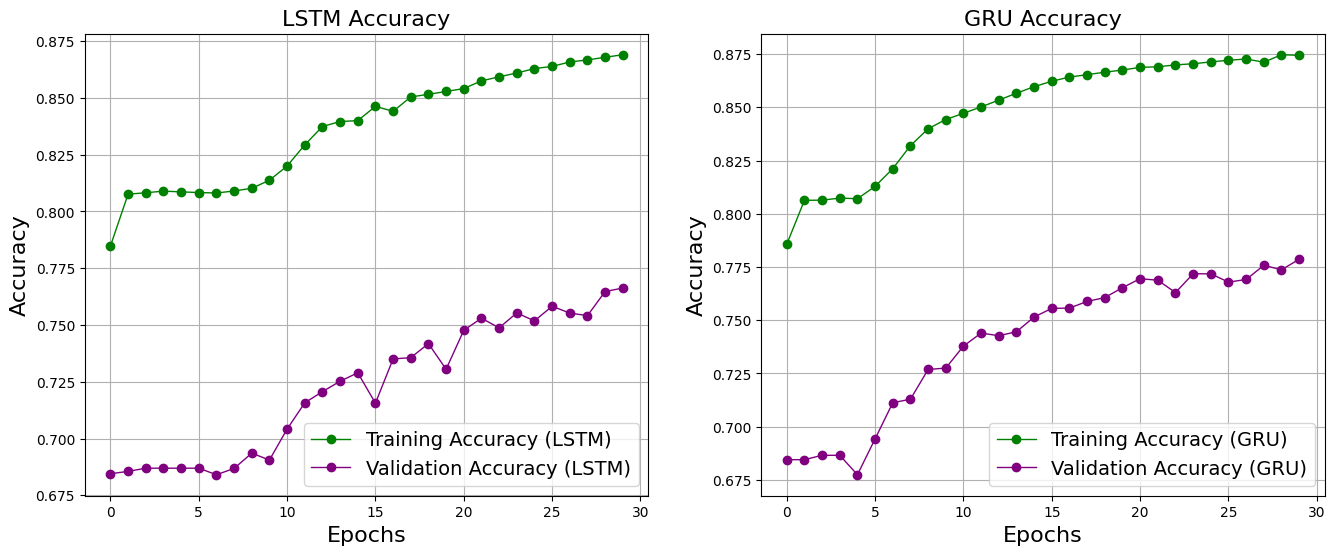

In [34]:
# plot Accuracy curves for LSTM and GRU models

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot LSTM accuracy
axes[0].plot(h_lstm.history['accuracy'], 'g', marker='o', linewidth=1.0)
axes[0].plot(h_lstm.history['val_accuracy'], 'purple', marker='o', linewidth=1.0)
axes[0].legend(['Training Accuracy (LSTM)', 'Validation Accuracy (LSTM)'], fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=16)
axes[0].set_ylabel('Accuracy', fontsize=16)
axes[0].set_title('LSTM Accuracy', fontsize=16)
axes[0].grid(True)

# Plot GRU accuracy
axes[1].plot(h_gru.history['accuracy'], 'g', marker='o', linewidth=1.0)
axes[1].plot(h_gru.history['val_accuracy'], 'purple', marker='o', linewidth=1.0)
axes[1].legend(['Training Accuracy (GRU)', 'Validation Accuracy (GRU)'], fontsize=14)
axes[1].set_xlabel('Epochs', fontsize=16)
axes[1].set_ylabel('Accuracy', fontsize=16)
axes[1].set_title('GRU Accuracy', fontsize=16)
axes[1].grid(True)

plt.show()

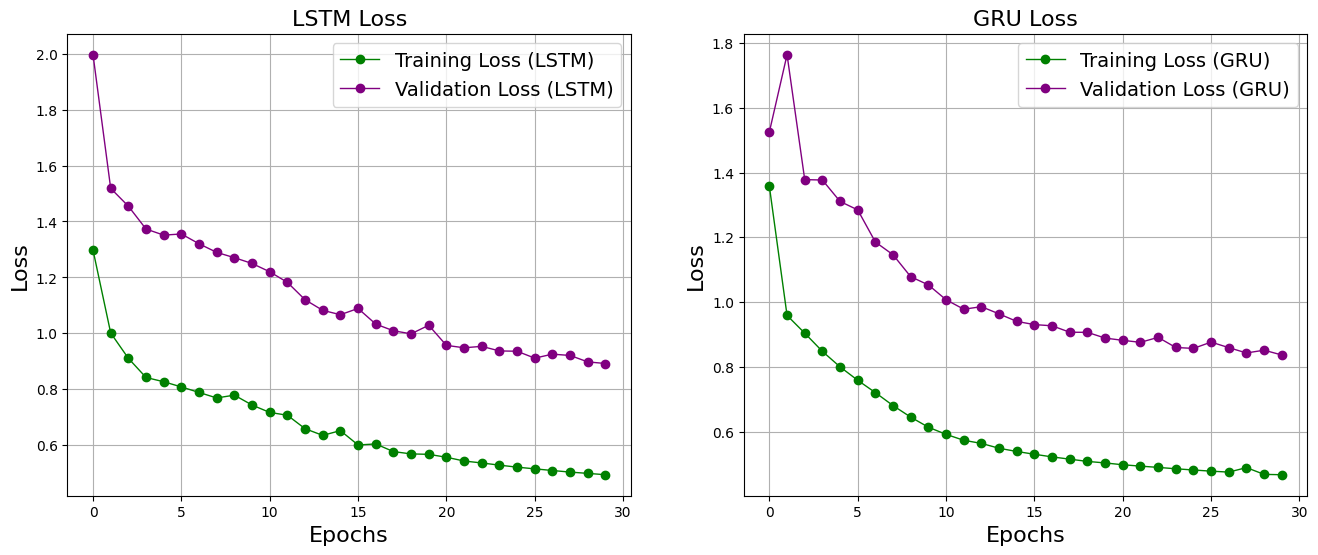

In [35]:
# plot Loss curves for LSTM and GRU models

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot LSTM loss
axes[0].plot(h_lstm.history['loss'], 'g', marker='o', linewidth=1.0)
axes[0].plot(h_lstm.history['val_loss'], 'purple', marker='o', linewidth=1.0)
axes[0].legend(['Training Loss (LSTM)', 'Validation Loss (LSTM)'], fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=16)
axes[0].set_ylabel('Loss', fontsize=16)
axes[0].set_title('LSTM Loss', fontsize=16)
axes[0].grid(True)

# Plot GRU loss
axes[1].plot(h_gru.history['loss'], 'g', marker='o', linewidth=1.0)
axes[1].plot(h_gru.history['val_loss'], 'purple', marker='o', linewidth=1.0)
axes[1].legend(['Training Loss (GRU)', 'Validation Loss (GRU)'], fontsize=14)
axes[1].set_xlabel('Epochs', fontsize=16)
axes[1].set_ylabel('Loss', fontsize=16)
axes[1].set_title('GRU Loss', fontsize=16)
axes[1].grid(True)

plt.show()

## *Inference*:


#### 1. The accuracy and loss curves for GRU achieved desired levels faster than LSTM
#### 2. Validation Acc. and Loss for LSTM was more unstable than GRU
#### 3. Although both models had largely similar performance, GRU can be preferred over LSTM. Additionally, GRU had a *1% better test accuracy* and *3% lower test loss*.